In [30]:
#!/bin/python3
from datetime import datetime, timezone
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

def get_data(start, end):
    api_url = "https://api.awattar.de/v1/marketdata"
    df = pd.DataFrame()

    start_timestamp = start
    end_timestamp = end

    params = {
        'start': start_timestamp,
        'end': end_timestamp
    }

    start_time = time.time()
    response = requests.get(api_url, params=params)
    end_time = time.time()

    print(f"took {end_time - start_time:.6f} seconds to execute.")

    if response.status_code == 200:
        data = response.json()

        with open(f'data/api_response_{start}_{end}.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

        return pd.DataFrame(data["data"])
    else:
        print(f"Fehler bei der Anfrage. Statuscode: {response.status_code}")
        return df

In [19]:
df = get_data(int(datetime(2023, 1, 1).timestamp() * 1000), int(datetime(2023, 12, 31).timestamp() * 1000))
assert not df.empty

df["marketprice"] = (df["marketprice"] * 0.1).round(2)
df["unit"] = "Cent/kWh"
df["date"] = df["start_timestamp"].apply(lambda epoch: datetime.fromtimestamp(epoch / 1000, tz=timezone.utc).strftime('%d-%m-%Y %H:%M:%S'))
df.drop(0, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
# df = df.head(100)
df

took 0.309961 seconds to execute.


,start_timestamp,end_timestamp,marketprice,unit,date
0,1672531200000,1672534800000,-0.11,Cent/kWh,01-01-2023 00:00:00
1,1672534800000,1672538400000,-0.15,Cent/kWh,01-01-2023 01:00:00
2,1672538400000,1672542000000,-0.51,Cent/kWh,01-01-2023 02:00:00
3,1672542000000,1672545600000,-0.45,Cent/kWh,01-01-2023 03:00:00
4,1672545600000,1672549200000,-0.54,Cent/kWh,01-01-2023 04:00:00
...,...,...,...,...,...
8274,1702317600000,1702321200000,12.14,Cent/kWh,11-12-2023 18:00:00
8275,1702321200000,1702324800000,11.40,Cent/kWh,11-12-2023 19:00:00
8276,1702324800000,1702328400000,9.92,Cent/kWh,11-12-2023 20:00:00
8277,1702328400000,1702332000000,9.65,Cent/kWh,11-12-2023 21:00:00


start_timestamp      int64
end_timestamp        int64
marketprice        float64
unit                object
date                object
dtype: object


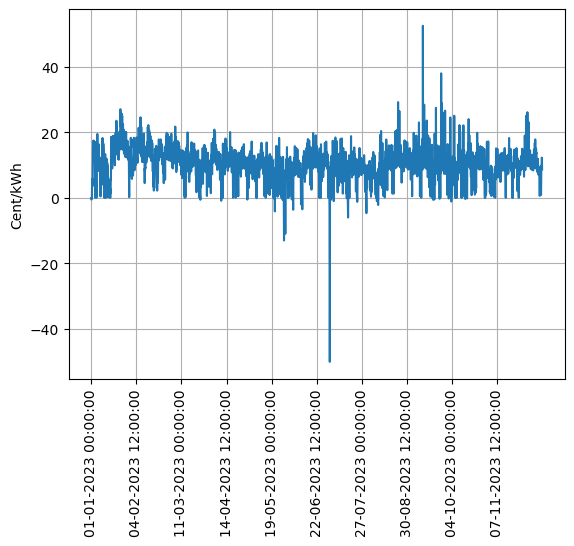

In [20]:

print(df.dtypes)
plt.plot(df["date"], df["marketprice"])
plt.ylabel(df["unit"].iloc[0])
plt.xticks(df["date"][::round(len(df["date"])/10)], rotation=90)
plt.grid()
plt.show()

828


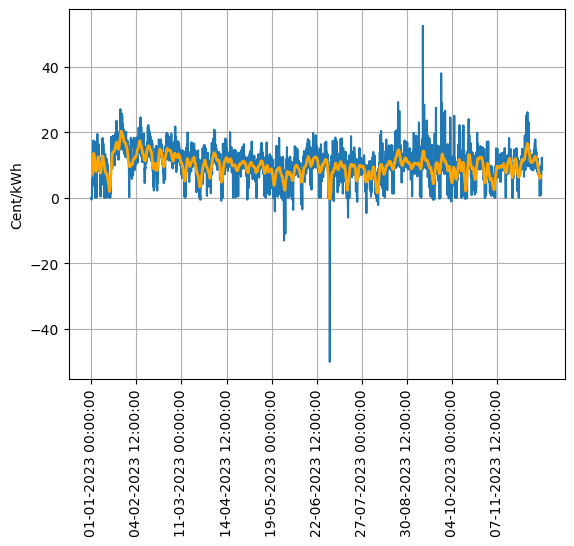

In [21]:
rolling_mean = df["marketprice"].rolling(window=48, center=True).mean()
# df = df.head(100)

plt.plot(df["date"], df["marketprice"], label='Original Data', linestyle='-')
plt.plot(df["date"], rolling_mean, label='Rolling Average', linestyle='-', linewidth=2, color='orange')
print(round(len(df["date"])/10))

plt.ylabel(df["unit"].iloc[0])
plt.xticks(df["date"][::round(len(df["date"])/10)], rotation=90)
plt.grid()
plt.show()

In [22]:
print(df.shape)

df

(8279, 5)


,start_timestamp,end_timestamp,marketprice,unit,date
0,1672531200000,1672534800000,-0.11,Cent/kWh,01-01-2023 00:00:00
1,1672534800000,1672538400000,-0.15,Cent/kWh,01-01-2023 01:00:00
2,1672538400000,1672542000000,-0.51,Cent/kWh,01-01-2023 02:00:00
3,1672542000000,1672545600000,-0.45,Cent/kWh,01-01-2023 03:00:00
4,1672545600000,1672549200000,-0.54,Cent/kWh,01-01-2023 04:00:00
...,...,...,...,...,...
8274,1702317600000,1702321200000,12.14,Cent/kWh,11-12-2023 18:00:00
8275,1702321200000,1702324800000,11.40,Cent/kWh,11-12-2023 19:00:00
8276,1702324800000,1702328400000,9.92,Cent/kWh,11-12-2023 20:00:00
8277,1702328400000,1702332000000,9.65,Cent/kWh,11-12-2023 21:00:00


In [23]:
df2 = pd.read_csv("data/Gro_handelspreise_202301010000_202312092359_Stunde.csv", delimiter=";")
df2 = df2[["Datum", "Anfang", "Ende", "Deutschland/Luxemburg [€/MWh] Originalauflösungen"]]
df2.rename(columns={"Deutschland/Luxemburg [€/MWh] Originalauflösungen": "marketprice"}, inplace=True)
df2["unit"] = "Cent/kWh"

df2['date'] = pd.to_datetime(df2['Datum'] + ' ' + df2['Anfang'].astype(str), format='%d.%m.%Y %H:%M')

# df.drop(0, axis=0, inplace=True)

df2

,Datum,Anfang,Ende,marketprice,unit,date
0,01.01.2023,00:00,01:00,"-5,17",Cent/kWh,2023-01-01 00:00:00
1,01.01.2023,01:00,02:00,"-1,07",Cent/kWh,2023-01-01 01:00:00
2,01.01.2023,02:00,03:00,"-1,47",Cent/kWh,2023-01-01 02:00:00
3,01.01.2023,03:00,04:00,"-5,08",Cent/kWh,2023-01-01 03:00:00
4,01.01.2023,04:00,05:00,"-4,49",Cent/kWh,2023-01-01 04:00:00
...,...,...,...,...,...,...
8227,09.12.2023,19:00,20:00,"69,45",Cent/kWh,2023-12-09 19:00:00
8228,09.12.2023,20:00,21:00,"64,46",Cent/kWh,2023-12-09 20:00:00
8229,09.12.2023,21:00,22:00,"60,41",Cent/kWh,2023-12-09 21:00:00
8230,09.12.2023,22:00,23:00,"56,84",Cent/kWh,2023-12-09 22:00:00


## Create energy consumption curve

[0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.55, 0.55, 0.55, 0.55, 1.8333333333333333, 1.8333333333333333, 1.8333333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.4583333333333333, 0.825, 0.825, 0.825, 0.825, 0.4583333333333333, 0.4583333333333333]
Total energy: 16.958333333333332


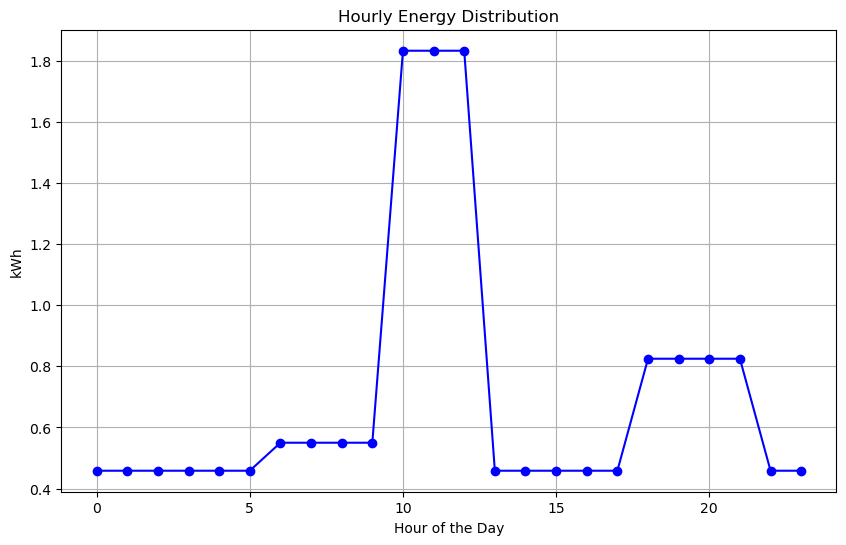

In [62]:
hours = list(range(24))
total_kwh_year = 4000
total_kwh_day = 11

def distribute_energy(total_kwh=11, hours=list(range(24))):
    morning_weight = 0.2
    midday_weight = 0.5
    evening_weight = 0.3
    
    energy_distribution = [0] * len(hours)
    
    for hour in hours:
        if 6 <= hour < 10:  # Morning spike
            energy_distribution[hour] = total_kwh * morning_weight / 4
        elif 10 <= hour < 13:  # Midday spike
            energy_distribution[hour] = total_kwh * midday_weight / 3
        elif 18 <= hour < 22:  # Evening spike
            energy_distribution[hour] = total_kwh * evening_weight / 4
        else:
            energy_distribution[hour] = total_kwh / 24  # Rest of the day
            
    return energy_distribution

energy_distribution = distribute_energy(total_kwh_day)
print(energy_distribution)
print(f"Total energy: {sum(energy_distribution)}")

plt.figure(figsize=(10, 6))
plt.plot(range(24), energy_distribution, marker='o', linestyle='-', color='b')
plt.title('Hourly Energy Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('kWh')
plt.grid(True)
plt.show()

[0.00813508 0.03217501 0.09910777 0.23776617 0.44436472 0.6475839
 0.73907529 0.67306159 0.5267511  0.43589405 0.46952543 0.57258454
 0.6278727  0.57768004 0.48600207 0.47551278 0.60077731 0.78076973
 0.86112463 0.75529207 0.51839139 0.27738979 0.11562535 0.03753748]
11.0


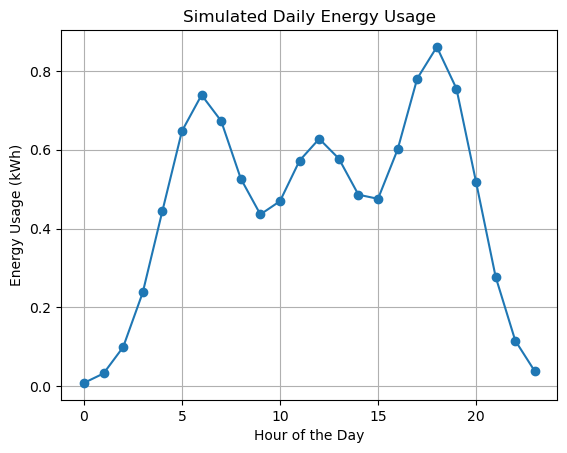

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_energy_usage(total_daily_energy=11, num_hours=24):
    # Create an array representing the hours of the day
    hours = np.arange(num_hours)

    # Define the function to model energy usage with spikes
    energy_usage = total_daily_energy * (
        0.6 * np.exp(-0.5 * ((hours - 6) / 2.0) ** 2) +
        0.5 * np.exp(-0.5 * ((hours - 12) / 2.0) ** 2) +
        0.7 * np.exp(-0.5 * ((hours - 18) / 2.0) ** 2)
    )

    # Ensure the energy usage is non-negative
    energy_usage = np.maximum(energy_usage, 0)

    # Normalize the energy usage to the total daily energy
    energy_usage = total_daily_energy * (energy_usage / np.sum(energy_usage))

    return energy_usage

energy_usage = simulate_energy_usage(11)
print(energy_usage)
print(sum(energy_usage))

# Plot the energy usage
plt.plot(hours, energy_usage, marker='o')
plt.title('Simulated Daily Energy Usage')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Usage (kWh)')
plt.grid(True)
plt.show()
